## Challenge Overview
 - Overview
   - [Assignment](#Assignment-Notes)
   - [Data Description](#Data)
 - [Submission](#Start)
   - [Part 1 - EDA](#Part-1---EDA)
   - [Part 2 - Experimental Metrics and Design](#Part-2---DoE)
   - [Part 3 - Predictive Modeling](#Part-3---Modeling)
     - [cleaning / target definition](#Cleaning,-Target-Definition) | [target relationships](#Target,-Feature-Relationships) | [data prep for modeling](#Data-Prep)
     - [model selection](#Model-Selection) | [model evaluation](#Final-Model-Evaluation) | [results and interpretations](#Results-and-Interpretation)    
---     

#### Assignment Notes

> Ultimate Technologies Inc. is a transportation network company that has disrupted the taxi and logistics industry and is considered a prestigious company to work for. This challenge has been adapted from an actual Ultimate Inc. data science challenge.

 - EDA
   - `logins.json` contains timestamps of user logins at a given location
     - **aggregate into 15 min intervals, visualize and describe patterns**
     - **report/illustrate demand features (such as daily cycles)**
     - **comment on possible data quality issues**
 - Experimental Metrics and Design
   - will reimbursing toll costs between Gotham / Metroplis encourage users to drive between the two cities?
     - **choose and justify key measure of success for this experiment**
     - **describe practical experimental design**
       - how to implement
       - how to interpret results, determine statistical significance
       - recommendations to city operations, along with caveats
    - *two cities not in dataset? but were described to have complemntary daytime/nighttime usage on weekdays and even usage on weekends.*
 - Modeling
   - predict rider retention. sample dataset has riders who signed up in Jan 2014 and whether they took a ride within the next several months.
   - use data to determine factors import to retention and provide suggestions for company to use them
     - **cleaning, EDA, visualizations for data. minimal word descriptions necessary. what fraction of sampled users were retained?**
     - **build predictive model to determine if user will be active (with?)in their 6th month. discuss choices, validity, and indicators of performance**
     - **describe how company can use insights to improve long-term retention**

#### Data

> Data description

|  **Feature**  | **Description** |
|--------------:|----------------:|
|  city | city this user signed up in |
|  phone | primary device for this user |
|  signup_date | date of account registration; in the form ‘YYYYMMDD’ |
|  last_trip_date | the last time this user completed a trip; in the form ‘YYYYMMDD’ |
|  avg_dist | the average distance in miles per trip taken in the first 30 days after signup |
|  avg_rating_by_driver | the rider’s average rating over all of their trips |
|  avg_rating_of_driver | the rider’s average rating of their drivers over all of their trips |
|  surge_pct | the percent of trips taken with surge multiplier > 1 |
|  avg_surge | The average surge multiplier over all of this user’s trips |
|  trips_in_first_30_days | the number of trips this user took in the first 30 days after signing up |
|  ultimate_black_user | `TRUE` if the user took an Ultimate Black in their first 30 days; `FALSE` otherwise |
|  weekday_pct | the percent of the user’s trips occurring during a weekday |

# Start

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import json

## Part 1 - EDA
  - data preparation, bulleted findings, graphs
  - referenced: [pandas timeseries](https://pandas.pydata.org/docs/getting_started/intro_tutorials/09_timeseries.html)

In [2]:
d = pd.read_json('logins.json')

In [3]:
d.sample(3)

,login_time
6610,1970-01-11 00:47:49
46402,1970-03-01 04:26:50
78881,1970-03-31 00:20:15


In [4]:
d.set_index('login_time', inplace=True)
d.loc[:,'logins'] = 1

In [5]:
d.sample(3)

,logins
login_time,
1970-02-19 23:28:07,1
1970-04-11 14:03:37,1
1970-01-22 13:32:05,1


In [6]:
d.index.min(), d.index.max()

(Timestamp('1970-01-01 20:12:16'), Timestamp('1970-04-13 18:57:38'))

In [7]:
dagg = d.resample('15min').sum()

In [8]:
dagg.sample(3)

,logins
login_time,
1970-03-04 15:00:00,4
1970-01-19 14:30:00,5
1970-01-23 13:15:00,7


**Trends** | *more illustrated and written on plots below*
  - overall: logins generally increased over the course of the data
  - time of day is important
    - one midday peak around 11-12, but most popular usage late at night/early morning. 21-24 and 0-4
  - more popular as week progresses. Fri,Sat,Sun busiest days
  - data quality
    - seems fine, time data is meant to be simulated, so it is ok that it starts at [Unix epoch](https://en.wikipedia.org/wiki/Unix_time)?
    - should only the login count be simulated for a more realistic time period?

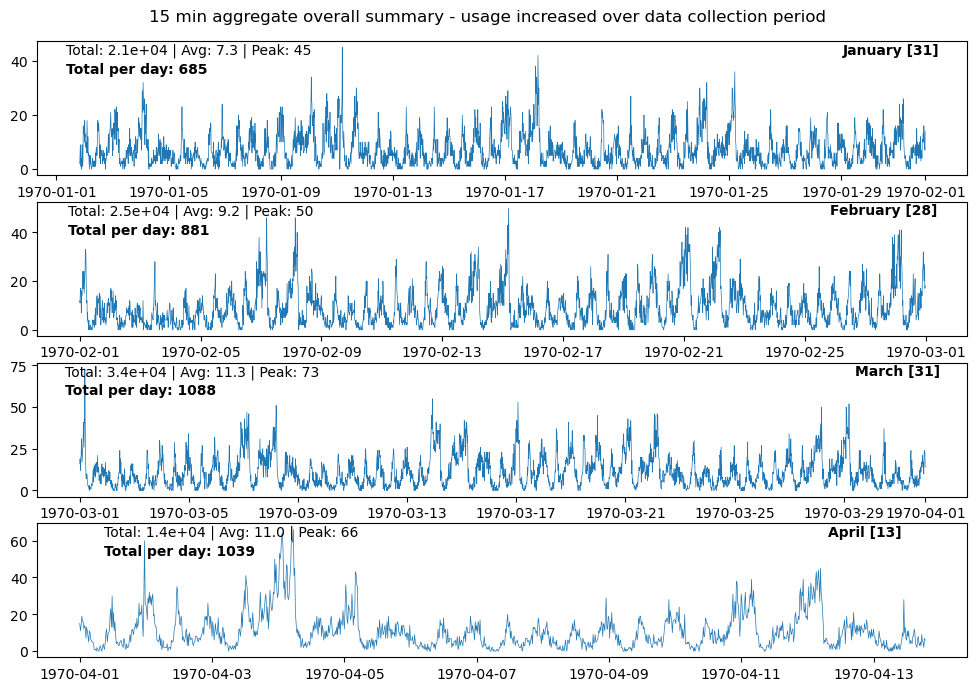

In [157]:
plt.figure(figsize=(12,8))

for i in range(4):
    plt.subplot(4,1,i+1)
    pdata = dagg[dagg.index.month==i+1]
    plt.plot(pdata,'-', linewidth=0.5)
    xb = plt.xlim()
    yb = plt.ylim()
    plt.text(xb[1]-1, yb[1]*0.9, f'{pdata.index[0].month_name()} [{pdata.index.day.unique().shape[0]}]',
             ha='right', fontweight='bold')
    plt.text(xb[0]+1, yb[1]*0.9,
             f'Total: {pdata.sum().values[0]:.1e} | Avg: {pdata.mean().values[0]:.1f} | Peak: {pdata.max().values[0]}',
            fontweight='normal')
    plt.text(xb[0]+1, yb[1]*0.75,
         f'Total per day: {pdata.sum().values[0]/pdata.index.day.unique().shape[0]:.0f}',
        fontweight='bold')
plt.suptitle('15 min aggregate overall summary - usage increased over data collection period', y=.92)
plt.show()

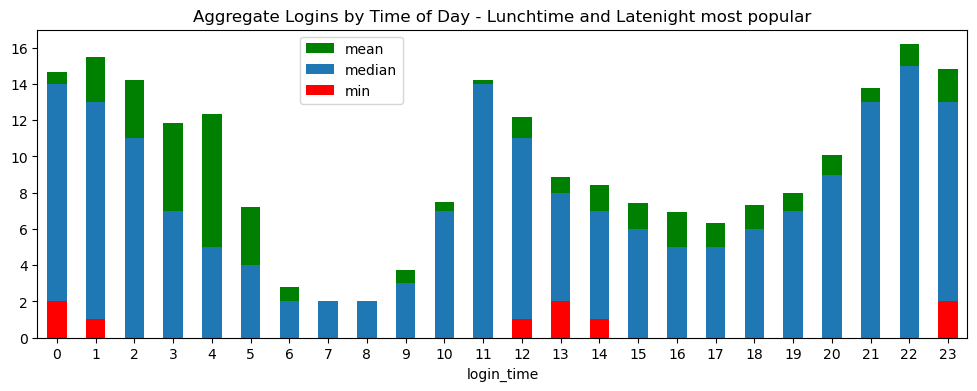

In [158]:
fig, axs = plt.subplots(figsize=(12, 4))

dagg.groupby(dagg.index.hour).mean().plot(
    kind='bar', rot=0, ax=axs, color='g',
)

dagg.groupby(dagg.index.hour).median().plot(
    kind='bar', rot=0, ax=axs
)

dagg.groupby(dagg.index.hour).min().plot(
    kind='bar', rot=0, ax=axs, color='red',
)

plt.legend(['mean','median','min'], bbox_to_anchor=(0.4,1))
plt.title('Aggregate Logins by Time of Day - Lunchtime and Latenight most popular')
plt.show()

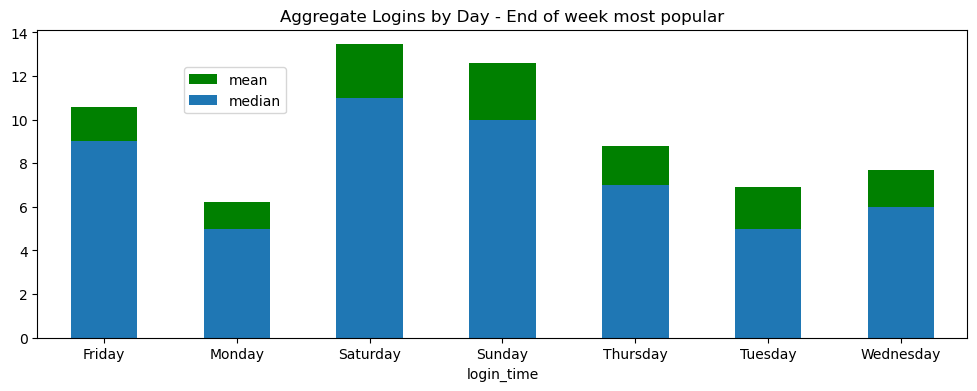

In [161]:
fig, axs = plt.subplots(figsize=(12, 4))

dagg.groupby(dagg.index.day_name(locale='en_US.utf8')).mean().plot(
    kind='bar', rot=0, ax=axs, color='g',
)

dagg.groupby(dagg.index.day_name(locale='en_US.utf8')).median().plot(
    kind='bar', rot=0, ax=axs
)


plt.legend(['mean','median'], bbox_to_anchor=(.15,.9))
plt.title('Aggregate Logins by Day - End of week most popular')
plt.show()

*Extra Plots*

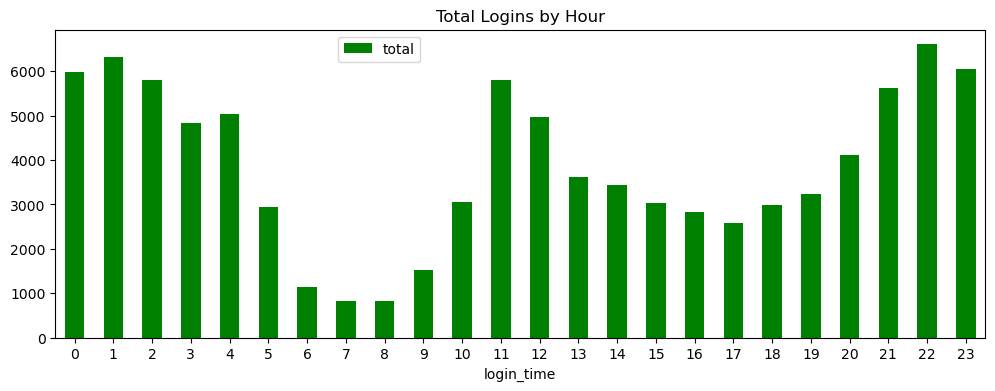

In [96]:
fig, axs = plt.subplots(figsize=(12, 4))

d.groupby(d.index.hour).sum().plot(
    kind='bar', rot=0, ax=axs, color='g',
)


plt.legend(['total'], bbox_to_anchor=(0.4,1))
plt.title('Total Logins by Hour')
plt.show()

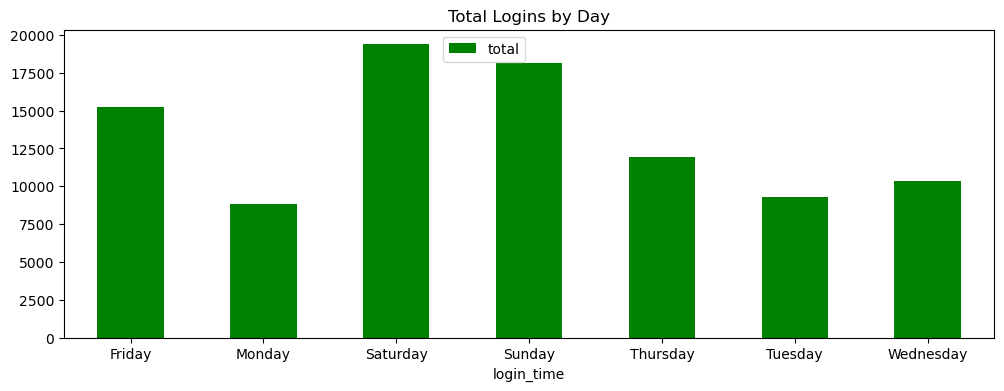

In [99]:
fig, axs = plt.subplots(figsize=(12, 4))

d.groupby(d.index.day_name(locale='en_US.utf8')).sum().plot(
    kind='bar', rot=0, ax=axs, color='g',
)


plt.legend(['total'], bbox_to_anchor=(0.4,1))
plt.title('Total Logins by Day')
plt.show()

## Part 2 - DoE

---

*drew picture below to check/organize understanding of problem statement*

 - ---
 - 1. **Measure of Success**: Increase in tolled rides vs cost of reimbursement.
   - characterize each ride with 0 for no commute or 1 for at least a one-way bridge crossing. determine baseline fraction of tolled rides for a given time period before the experimental window.
     - as shown above (EDA), various aggregate trends should be noted for better comparisons 
   - this measure will be simple and be most direct in terms of desired outcome
   - reimbursement cost should also be considered, and the baseline tolled rides rate can be used for adjustment
   - for a starting experiment, simple metrics and success critieria may be more helpful than trying to optimize something without understanding it
     - for example, trying to measure rides in certain directions or at certain times of day should wait until future experiments
 - ---
 - 2. **Implementation**
   - for one "promotional" month, Ultimate will reimburse all tolls between Gotham and Metropolis on weekdays
   - the above mentioned metric will be determined for the experiment window
 - ---
 - 3. **Interpretation**
   - *null hypothesis*
     - tolled rides will not increase during the experimental window, therefore showing tolls may not be the only reason drivers choose not to commute between the cities.
   - if the results do not confirm the null hypothesis, then the experiment indicates that reimbursing tolls contributed to increased rides between the two cities. it will also be valuable to see if there were any differences in tolled rides on the weekends, during which tolls were unaffected by the experiment. 
 - ---
 - 4. **Recommendations to City Operations**
   - *assumptions/background*: I am imagining being a stakeholder for the company who would want the cities to promote driving as much as possible. It's possible city operators are satisfied with the toll's effects on commuters and choices for transportation, and worth learning more about their motivations. I will assume that there was a significant increase in tolled rides during the experimental window, and even indications that tolled rides increased on the weekends.
   - **communicate results**
     - increased intercity commutes, gained economic opportunity for each city with more population mixing
     - note cost *Ultimate* reimbursed in Toll Fees, and how much was estimated to be "above baseline"
     - be transparent about imbalanced flow and patterns of occurence. for example, it is likely most of the afternoon/evening traffic will be from Metroplis to Gotham
     - if alternative public transportation is available, note possible spikes in *Ultimate* ridership after closing. for example, sample login data showed high usage between 12am and 2am
   - **propose toll reduction options** (this feels aggressive)
     - cities remove toll outside of main commuting window and on weekends
       - could keep exceptions for special events / holidays
     - *Ultimate* reimburses users full-price of tolls at all other times, and city agrees to provide *Ultimate* with a rebate for half of its reimbursements
       - users will effectively have no toll, and *Ultimate* will take on half the cost and initially, the full payment to the city
     - decreased toll revenues to cities should be justified with other estimated benefits, communicated with the results
   - **caveats**
     - depending on the balance of commutes, it may make more sense to for the toll to have a scheduled cost with direction of travel taken into account
     - the cities may not want to equally lose revenue. Gotham may see more benefit from increased commuting, if most users are leaving Metropolis
     - fully removing the toll may not be necessary to encourage more use of the bridge
 - ---

In [165]:
import IPython

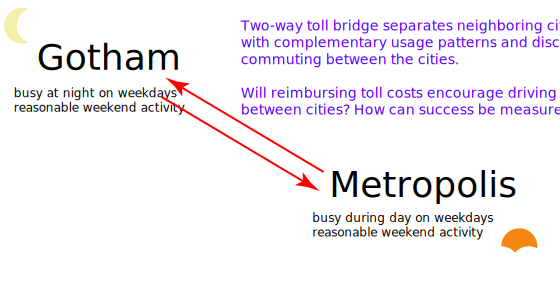

In [171]:
IPython.display.SVG(filename="./part2.svg")

In [9]:
# IPython.display.SVG(url="GITHUB LINK")

## Part 3 - Modeling

   - predict rider retention. sample dataset has riders who signed up in Jan 2014 and whether they took a ride within the next several months.
   - use data to determine factors import to retention and provide suggestions for company to use them
     - **cleaning, EDA, visualizations for data. minimal word descriptions necessary. what fraction of sampled users were retained?**
       - <font color="green">answer: `37.6%`</font> | [cleaning / target definition](#Cleaning,-Target-Definition)
     - **build predictive model to determine if user will be active (with?)in their 6th month. discuss choices, validity, and indicators of performance**
       - *see* [model selection](#Model-Selection) | [model evaluation](#Final-Model-Evaluation)
     - **describe how company can use insights to improve long-term retention**
       - *see* [results and interpretations](#Results-and-Interpretation)

---
**Part 3 Contents**
 - [cleaning / target definition](#Cleaning,-Target-Definition)
 - [target relationships](#Target,-Feature-Relationships)
 - [data prep for modeling](#Data-Prep)
 - [model selection](#Model-Selection)
 - [model evaluation](#Final-Model-Evaluation)
 - [results and interpretations](#Results-and-Interpretation)

In [10]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, scale
# from sklearn.feature_selection import SelectKBest # manually removed some features, will not pare down further
from sklearn.model_selection import cross_validate, train_test_split, RandomizedSearchCV

from sklearn.linear_model import LogisticRegression, RidgeClassifier, SGDClassifier, Perceptron
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier

from sklearn.metrics import classification_report, precision_recall_curve, roc_auc_score, \
                            auc, roc_curve, RocCurveDisplay, confusion_matrix, ConfusionMatrixDisplay, \
                            accuracy_score, balanced_accuracy_score, precision_score, recall_score
from sklearn.inspection import permutation_importance
from scipy import stats

from tqdm import tqdm
from time import time

In [18]:
def score_pred(true, pred):
    return {
        'accuracy': round(accuracy_score(true,pred),3),
        'balanced_accuracy': round(balanced_accuracy_score(true,pred),3),
        'precision': round(precision_score(true,pred),3),
        'recall': round(recall_score(true,pred),3),
        'roc_auc': round(roc_auc_score(true,pred),3),
    }

### Cleaning, Target Definition
   - 3 different cities
   - convert date dtypes
   - *define target*
     - user is **"retained"** if they took ride in preceding 30 days. will assume data was pulled at latest `last_trip_date`
     - data pulled on **2014-07-01** | `d.last_trip_date.max()`
     - user retained if last_trip_date on **2014-06-01 or later** | `d.last_trip_date.max()-pd.Timedelta('30 days')`

In [11]:
d = pd.read_json('ultimate_data_challenge.json')
# d.info()

In [12]:
for col in ['signup_date', 'last_trip_date']:
    d[col] = pd.to_datetime(d.loc[:,col])

In [13]:
# target variable: retained = took trip within last 30 days.
d.loc[:,'retained'] = d.last_trip_date >= (d.last_trip_date.max()-pd.Timedelta('30 days'))

In [4]:
d.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9


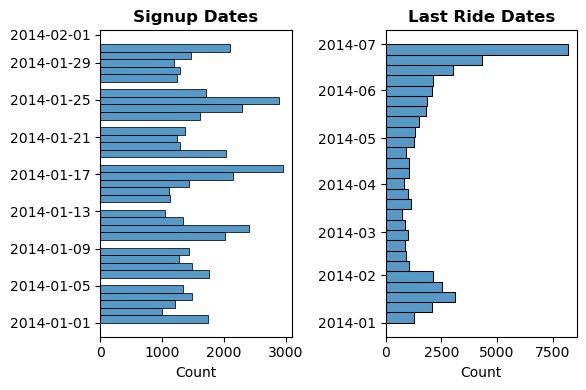

In [261]:
plt.figure(figsize=(6,4), tight_layout=True)
plt.subplot(121)
sns.histplot(y=d.signup_date)
plt.ylabel('')
plt.title('Signup Dates', fontweight='bold')
plt.subplot(122)
sns.histplot(y=d.last_trip_date)
plt.ylabel('')
plt.title('Last Ride Dates', fontweight='bold')
plt.show()

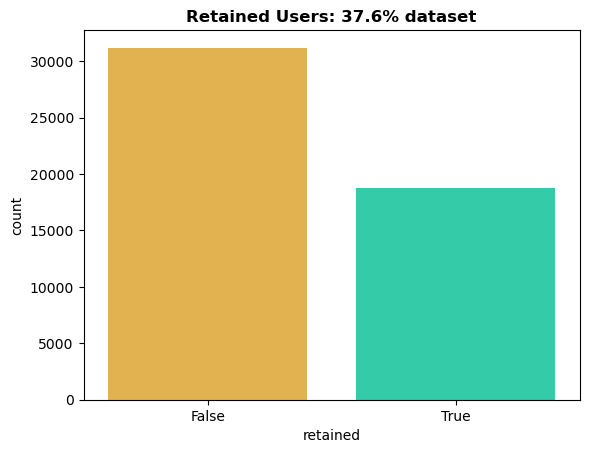

In [8]:
sns.countplot(x=d.retained, palette='turbo_r')
plt.title(f'Retained Users: {100*d.retained.mean():.1f}% dataset',
          fontweight='bold')
plt.show()

### Target, Feature Relationships
 - `signup_date` | no relation
   - checked by day of week, too
 - `city` | riders who signed up from King's Landing had much higher retention rate, Winterfell had the most total riders and retained riders
 - `trips_in_first...` | normally distributed above 0
   - most of dataset had between 0-4 in rides in first 30 days, and retention rate was low/population average
   - a few riders had 5 or greater rides in the first 30 days, and retention rate was about double the population average
 - `phone` | iPhone,Android,None
   - iPhone has higher retention rate than other two, more users
 - `ultimate_black_user`
   - less common, but higher retention rate
 - *numerical*
   - slight correlation with ultimate_black_user and trips in first month with retention, as noted above
   - other features show little correlation with target, but some intercorrelation
     - avg surge, surge pct are highly intercorrelated, as they have similar definitions and meanings
     - rides on weekdays might tend to be longer distances
     - drivers may rate riders slightly better on longer drives

In [250]:
d.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,retained
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0,True
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0,False
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0,False
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9,True
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9,False


*Check Feature Relations*

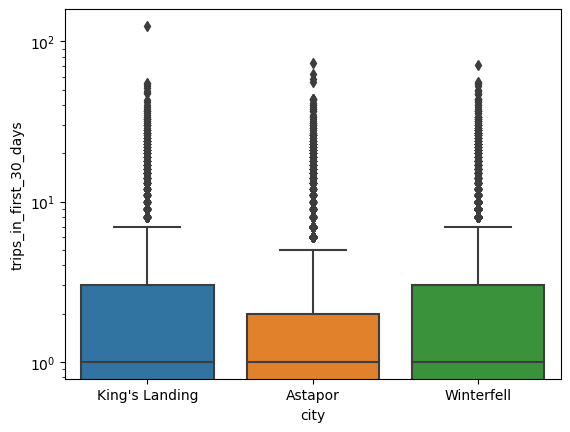

In [312]:
sns.boxplot(d,x='city',y='trips_in_first_30_days')
plt.yscale('log')

In [306]:
f1 = 'city'
f2 = 'trips_in_first_30_days'

for f1_v in d[f1].unique():
    print(f1_v, f2, str(d[d[f1]==f1_v][f2].mean().round(2)).rjust(25-len(str(f1_v))))

King's Landing trips_in_first_30_days        2.46
Astapor trips_in_first_30_days               1.95
Winterfell trips_in_first_30_days            2.43


*signup date*

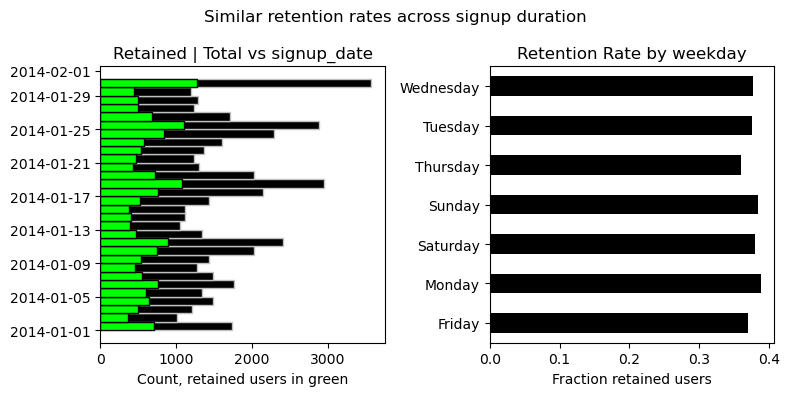

In [118]:
plt.figure(figsize=(8,4), tight_layout=True)
plt.subplot(121)
plt.hist(x = d.signup_date, orientation='horizontal',
         color='k', edgecolor='silver', bins=np.sort(d.signup_date.unique()))
plt.hist(x = d[d.retained==True].signup_date, orientation='horizontal',
         color='lime', edgecolor='k', bins=np.sort(d.signup_date.unique()))
plt.title('Retained | Total vs signup_date')
plt.xlabel('Count, retained users in green')
plt.subplot(122)
d.groupby(d.signup_date.dt.day_name(locale='en_US.utf8')).retained.mean().plot(kind='barh', rot=0, color='k',)
plt.title('Retention Rate by weekday')
plt.ylabel('')
plt.xlabel('Fraction retained users')
plt.suptitle('Similar retention rates across signup duration')

plt.show()

*weekday_pct*

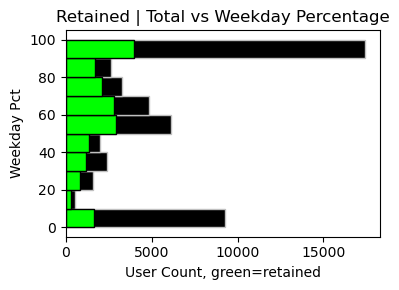

In [322]:
plt.figure(figsize=(4,3), tight_layout=True)
plt.hist(x = d.weekday_pct, orientation='horizontal',
         color='k', edgecolor='silver', bins=np.arange(0,110,10))
plt.hist(x = d[d.retained==True].weekday_pct, orientation='horizontal',
         color='lime', edgecolor='k', bins=np.arange(0,110,10))
plt.ylabel('Weekday Pct')
plt.xlabel('User Count, green=retained')
plt.title('Retained | Total vs Weekday Percentage')
plt.show()

*city*

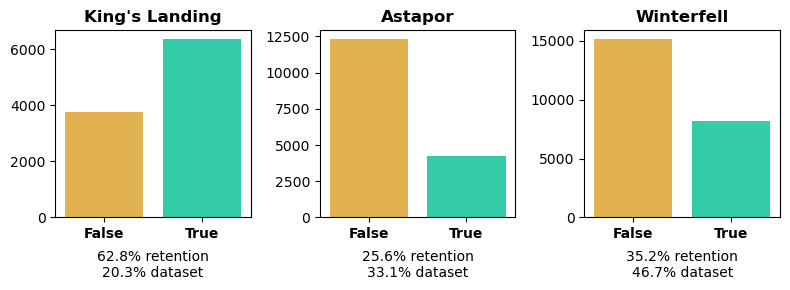

In [300]:
plt.figure(figsize=(8,3), tight_layout=True)
for i,c in enumerate(d.city.unique()):
    plt.subplot(1,3,i+1)
    sns.countplot(x=d[d.city==c].retained, palette='turbo_r')
    plt.title(c, fontweight='bold')
    plt.text(0.5,1, f'\n\n{100*d[d.city==c].retained.mean():.1f}% retention\n{100*d[d.city==c].shape[0]/d.shape[0]:.1f}% dataset',
             ha='center', va='top')
    plt.ylabel('')
    plt.xlabel('')
    plt.xticks(fontweight='bold')
plt.show()

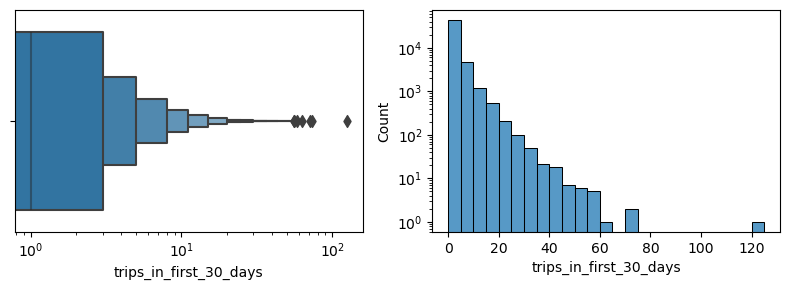

In [299]:
plt.figure(figsize=(8,3), tight_layout=True)
plt.subplot(1,2,1)
sns.boxenplot(x = d.trips_in_first_30_days)
plt.xscale('log')
plt.subplot(1,2,2)
sns.histplot(x = d.trips_in_first_30_days, binwidth=5)
plt.yscale('log')

*first month trips*

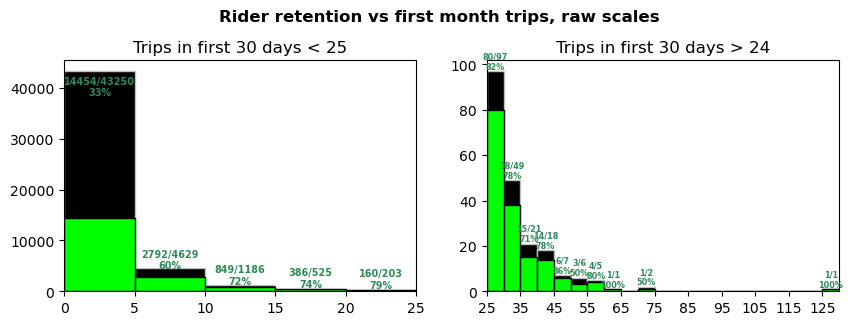

In [491]:
bins = np.arange(0, d.trips_in_first_30_days.max()+10, 5)

plt.figure(figsize=(10,3))
plt.subplot(121)
plt.hist(x = d[(d.trips_in_first_30_days<25)].trips_in_first_30_days, bins=bins,
         color='k', edgecolor='silver')
plt.hist(x = d[(d.retained==True)&(d.trips_in_first_30_days<25)].trips_in_first_30_days, bins=bins,
         color='lime', edgecolor='k')
plt.xlim((0,25))
for i,val in enumerate(bins[0:5]):
    rate = d[d.trips_in_first_30_days.between(val,bins[i+1], inclusive='left')].value_counts('retained')
    if rate.sum()>0:
        plt.text(bins[i+1]-2.5, rate.sum()*0.88, 
                 f'{rate[True]}/{rate.sum()}\n{100*rate[True]/rate.sum():.0f}%', color='seagreen',
                 ha='center', va='bottom', fontsize='x-small', fontweight='bold')
plt.title('Trips in first 30 days < 25')
plt.subplot(122)
plt.hist(x = d[(d.trips_in_first_30_days>=25)].trips_in_first_30_days, bins=bins,
         color='k', edgecolor='silver')
plt.hist(x = d[(d.retained==True)&(d.trips_in_first_30_days>=25)].trips_in_first_30_days, bins=bins,
         color='lime', edgecolor='k')
plt.xlim((25,130))
plt.xticks(np.arange(25,130,10))
for i,val in enumerate(bins[5:-1]):
    rate = d[d.trips_in_first_30_days.between(val,bins[i+6], inclusive='left')].value_counts('retained')
    if rate.sum()>0:
        plt.text(bins[i+6]-2.5, rate.sum(), 
                 f'{rate[True]}/{rate.sum()}\n{100*rate[True]/rate.sum():.0f}%', color='seagreen',
                 ha='center', va='bottom', fontsize='xx-small', fontweight='bold')
plt.title('Trips in first 30 days > 24')
plt.suptitle('Rider retention vs first month trips, raw scales', y=1.05, fontweight='bold')
plt.show()

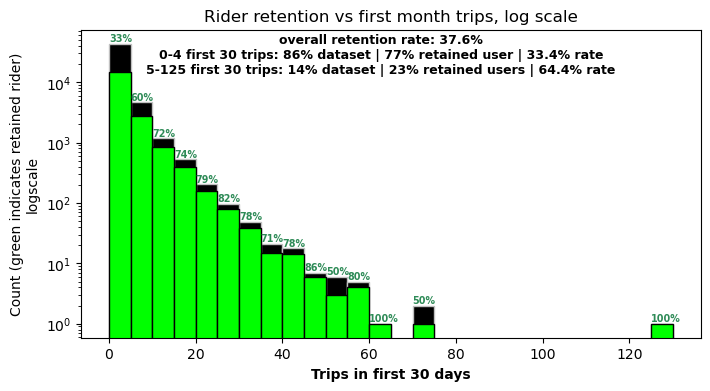

In [509]:
bins = np.arange(0, d.trips_in_first_30_days.max()+10, 5)

plt.figure(figsize=(8,4))
plt.hist(x = d.trips_in_first_30_days, bins=bins,
         color='k', edgecolor='silver')
plt.hist(x = d[d.retained==True].trips_in_first_30_days, bins=bins,
         color='lime', edgecolor='k')
plt.yscale('log')

for i,val in enumerate(bins[:-1]):
    rate = d[d.trips_in_first_30_days.between(val,bins[i+1], inclusive='left')].value_counts('retained')
    if rate.sum()>0:
        plt.text(val, rate.sum(), f'{100*rate[True]/rate.sum():.0f}%', color='seagreen',
             ha='left', va='bottom', fontsize='x-small', fontweight='bold')
plt.title("Rider retention vs first month trips, log scale")
plt.suptitle(f'overall retention rate: {100*d.retained.sum()/d.shape[0]:.1f}%\n\
0-4 first 30 trips: {100*d[d.trips_in_first_30_days.between(0,4)].shape[0]/d.shape[0]:.0f}% dataset | \
{100*d[d.trips_in_first_30_days.between(0,4)].retained.sum()/d.retained.sum():.0f}% retained user | \
{100*d[d.trips_in_first_30_days.between(0,4)].retained.sum()/d[d.trips_in_first_30_days.between(0,4)].shape[0]:.1f}% rate\n\
5-125 first 30 trips: {100*d[d.trips_in_first_30_days>4].shape[0]/d.shape[0]:.0f}% dataset | \
{100*d[d.trips_in_first_30_days>4].retained.sum()/d.retained.sum():.0f}% retained users | \
{100*d[d.trips_in_first_30_days>4].retained.sum()/d[d.trips_in_first_30_days>4].shape[0]:.1f}% rate',
             y=0.87,
             fontsize=9, fontweight='bold')
plt.xlabel("Trips in first 30 days", fontweight='bold')
plt.ylabel("Count (green indicates retained rider)\nlogscale")
plt.show()

*special user*

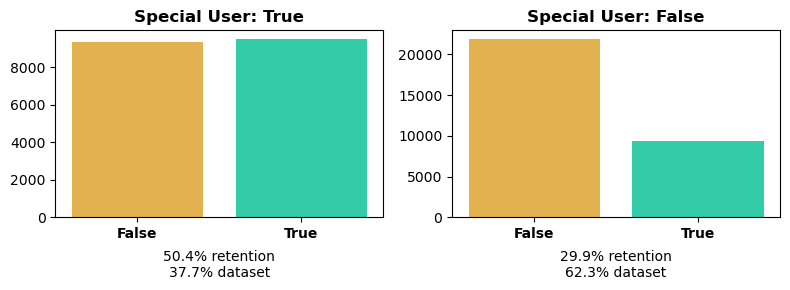

In [25]:
plt.figure(figsize=(8,3), tight_layout=True)
for i,c in enumerate(d.ultimate_black_user.unique()):
    plt.subplot(1,2,i+1)
    sns.countplot(x=d[d.ultimate_black_user==c].retained, palette='turbo_r')
    plt.title(f'Special User: {c}', fontweight='bold')
    plt.text(0.5,1, f'\n\n{100*d[d.ultimate_black_user==c].retained.mean():.1f}% retention\n{100*d[d.ultimate_black_user==c].shape[0]/d.shape[0]:.1f}% dataset',
             ha='center', va='top')
    plt.ylabel('')
    plt.xlabel('')
    plt.xticks(fontweight='bold')
plt.show()

*phone*

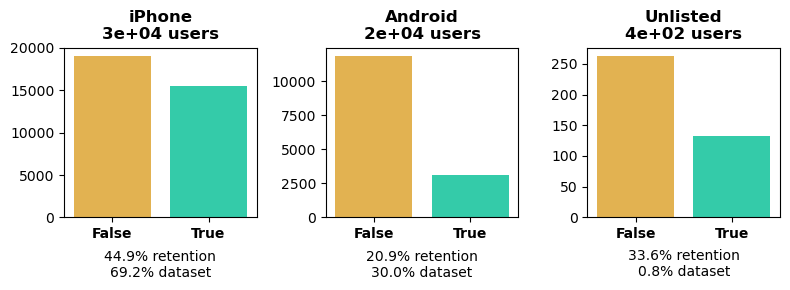

In [21]:
plt.figure(figsize=(8,3), tight_layout=True)
for i,c in enumerate(d.phone.unique()):
    plt.subplot(1,3,i+1)
    if c == None:
        sns.countplot(x=d[d.phone.isna()].retained, palette='turbo_r')
        plt.text(0.5,1, f'\n\n{100*d[d.phone.isna()].retained.mean():.1f}% retention\n{100*d[d.phone.isna()].shape[0]/d.shape[0]:.1f}% dataset',
                 ha='center', va='top')
        plt.title(f'Unlisted\n{d[d.phone.isna()].shape[0]:.0e} users', fontweight='bold')
    else:
        sns.countplot(x=d[d.phone==c].retained, palette='turbo_r')
        plt.text(0.5,1, f'\n\n{100*d[d.phone==c].retained.mean():.1f}% retention\n{100*d[d.phone==c].shape[0]/d.shape[0]:.1f}% dataset',
                 ha='center', va='top')
        plt.title(f'{c}\n{d[d.phone==c].shape[0]:.0e} users', fontweight='bold')

    plt.ylabel('')
    plt.xlabel('')
    plt.xticks(fontweight='bold')
plt.show()

*feature and target correlations*

<Axes: >

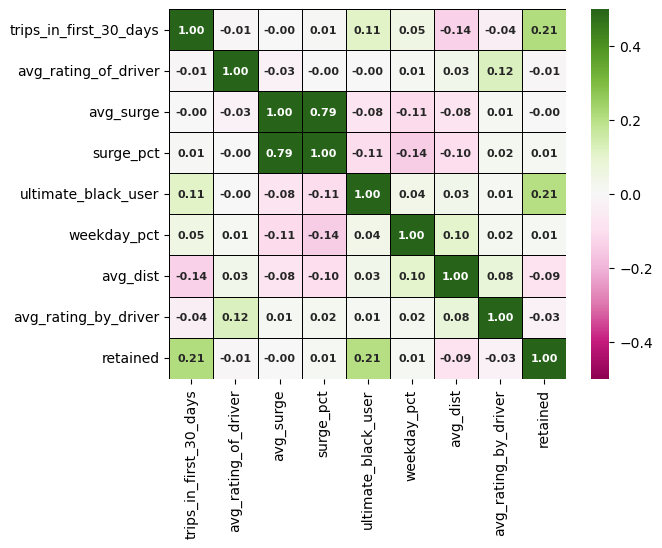

In [33]:
sns.heatmap(d.corr(numeric_only=True), cmap='PiYG', linecolor='k', linewidths=0.5,
           vmin=-0.5, vmax=0.5,yticklabels=True, xticklabels=True, fmt=".2f",
           annot=True, annot_kws=dict(fontsize=8,fontweight='bold'))

### Data Prep 
logistic regression model to predict retainment
 - *feature adjustments*
   - **encode categorical text data**
     - `city`, `phone`
   - **drop date features**
     - no obvious relationships between `signup` and target
     - `last_trip` used to define target
   - **drop rating columns**
     - no obvious relationships between ratings and target
     - missing data
   - **avg surge vs surge pct** = "users lifetime avg surge multiplier" vs "users lifetime percent trips with surge rates"
     - surge pct higher R2, both are very low
     - multiplying two increases R2 by factor of 4, still very low
       - **combine into `surge` and drop originals**
   - **dtypes**
     - change `ultimate_black_user` from boolean to int
     - not needed, but convenient for using df index for normalization
 - **z-score normalization**
   - numerical columns only: `['trips_in_first_30_days','weekday_pct','avg_dist','surge']`


*surge feature engineering --> choose highest R2 with target*

In [145]:
print(f'Surge Pct R2: {d.retained.corr(d.surge_pct)**2:.2e}')
print(f'Surge Avg R2: {d.retained.corr(d.avg_surge)**2:.2e}')
print(f'Pct*Avg combo: {d.retained.corr(d.surge_pct*d.avg_surge)**2:.2e}')

Surge Pct R2: 1.39e-04
Surge Avg R2: 1.11e-05
Pct*Avg combo: 5.71e-04


In [159]:
mdata = d.copy()

*encode categorical features*

In [160]:
# Encode, add encoded, drop original cities
enc = OneHotEncoder()
enc.fit(mdata.city.values.reshape(-1,1))
enc.sparse_output=False
# enc.categories_
new = enc.transform(mdata.city.values.reshape(-1,1))
for i,col in enumerate(enc.categories_[0]):
    mdata.loc[:,f'city_{col}'] = new[:,i]
mdata.drop(columns='city', inplace=True)

In [161]:
# Encode, add encoded, drop original phones
enc = OneHotEncoder()
enc.fit(mdata.phone.values.reshape(-1,1))
enc.sparse_output=False
enc.categories_
new = enc.transform(mdata.phone.values.reshape(-1,1))
for i,col in enumerate(enc.categories_[0]):
    mdata.loc[:,f'phone_{col if col else "unlisted"}'] = new[:,i]
mdata.drop(columns='phone', inplace=True)

*more conversions/drops*

In [162]:
# drop unused features
mdata.drop(columns=['avg_rating_of_driver', 'avg_rating_by_driver',
                    'signup_date', 'last_trip_date'], inplace=True)

# combine surge into one feature
mdata.loc[:,'surge'] = mdata.surge_pct*mdata.avg_surge
mdata.drop(columns=['avg_surge','surge_pct'], inplace=True)

# convert special user to int from bool
mdata.loc[:,'special_user'] = mdata.ultimate_black_user.astype(int)
mdata.drop(columns='ultimate_black_user', inplace=True)

In [171]:
mdata.sample(3)

,trips_in_first_30_days,weekday_pct,avg_dist,retained,city_Astapor,city_King's Landing,city_Winterfell,phone_Android,phone_iPhone,phone_unlisted,surge,special_user
5875,7,74.4,1.34,True,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1
40382,1,0.0,16.06,False,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1
26620,0,100.0,0.00,True,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0


*z-score normamlization*

In [172]:
scale_cols = ['trips_in_first_30_days','weekday_pct','avg_dist','surge']
mdata[scale_cols] = scale(mdata[scale_cols])

In [173]:
mdata.sample(3)

,trips_in_first_30_days,weekday_pct,avg_dist,retained,city_Astapor,city_King's Landing,city_Winterfell,phone_Android,phone_iPhone,phone_unlisted,surge,special_user
24315,-0.337021,1.053741,-0.066025,True,0.0,0.0,1.0,0.0,1.0,0.0,0.242781,0
27223,1.244988,0.064020,-0.549617,True,0.0,0.0,1.0,0.0,1.0,0.0,-0.065862,0
48584,2.035993,-0.197569,-0.213205,True,0.0,0.0,1.0,0.0,1.0,0.0,-0.254404,1


In [175]:
mdata.to_parquet('model_data.parquet')

### Model Selection
 - split data
 - basic model selection with 10-fold cross-validation
   - considered various metrics and time
     - `['accuracy','balanced_accuracy','precision','recall', 'roc_auc']`
   - continue with: LogReg, ExtraTrees, GradientBoosting classifiers
 - tuning, deeper evaluation
   - evaluate selected 4, establish baseline
     - confusion matrics, roc-auc curves, feature importance
   - quick tuning via RandomizedSearchCV

In [5]:
mdata = pd.read_parquet('model_data.parquet')
X_train, X_test, y_train, y_test = \
    train_test_split(mdata.drop(columns='retained'), mdata['retained'], 
                     test_size=0.2, random_state=42, stratify=mdata['retained'])
X_train.shape, X_test.shape

((40000, 11), (10000, 11))

*stratification checks*

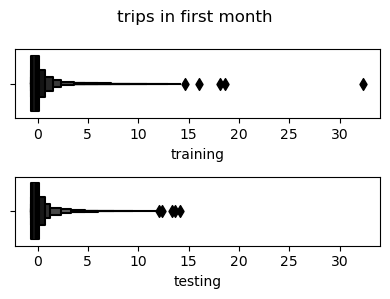

In [208]:
plt.figure(figsize=(4,3), tight_layout=True)
plt.subplot(211)
sns.boxenplot(x=X_train.trips_in_first_30_days, color='k')
plt.xlabel('training')
xb = plt.xlim()
plt.subplot(212)
sns.boxenplot(x=X_test.trips_in_first_30_days, color='k')
plt.xlabel('testing')
plt.xlim(xb)
plt.suptitle('trips in first month')
plt.show()

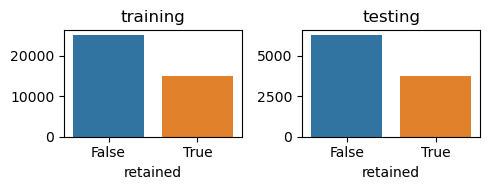

In [198]:
plt.figure(figsize=(5,2), tight_layout=True)
plt.subplot(121)
sns.countplot(x=y_train)
plt.ylabel('')
plt.title('training')
plt.subplot(122)
sns.countplot(x=y_test)
plt.ylabel('')
plt.title('testing')
plt.show()

##### Model Selection CV

In [16]:
%%time
cv_results = pd.DataFrame()

for mod in tqdm([LogisticRegression(), RidgeClassifier(), SGDClassifier(),
                 ExtraTreesClassifier(), GradientBoostingClassifier(),
                 KNeighborsClassifier(20), MLPClassifier(), RandomForestClassifier(), 
                ]):
# for mod in [LogisticRegression()]:
    cv = cross_validate(mod, X_train, y_train, cv=10, n_jobs=-1,
                        scoring=['accuracy','balanced_accuracy','precision','recall', 'roc_auc'])
    name = mod.__class__.__name__
    cvk = pd.Series(cv.keys())
    cvk = cvk[cvk.str.startswith('test_')]
    for k in cvk.values:
        cv_results.loc[name, k.replace('test_','')] = round(np.mean(cv[k]),3)
    cv_results.loc[name, 'total_time'] = round(np.sum(cv['score_time']) + np.sum(cv['fit_time']),1)

100%|██████████| 8/8 [01:00<00:00,  7.56s/it]

CPU times: total: 500 ms
Wall time: 1min


In [17]:
cv_results.sort_values('balanced_accuracy', ascending=False).style\
    .background_gradient(cmap='Spectral', subset=cv_results.columns[:-1],  axis=None,)\
    .background_gradient(cmap='Spectral_r', subset='total_time')\
    .format(formatter="{:.3f}")

,accuracy,balanced_accuracy,precision,recall,roc_auc,total_time
GradientBoostingClassifier,0.778,0.752,0.734,0.644,0.844,43.600
MLPClassifier,0.775,0.746,0.732,0.632,0.838,303.500
KNeighborsClassifier,0.759,0.728,0.715,0.599,0.818,19.400
ExtraTreesClassifier,0.729,0.712,0.639,0.642,0.771,75.400
RandomForestClassifier,0.730,0.712,0.642,0.639,0.795,106.400
LogisticRegression,0.717,0.674,0.665,0.498,0.761,1.900
RidgeClassifier,0.715,0.668,0.670,0.478,0.760,1.000
SGDClassifier,0.704,0.648,0.669,0.421,0.750,2.600


##### Classification Evaluation
 - using selected 4 "best" models from above
   - `LogisticRegression`, `kNeighbors [n=20]`, `GradientBoosting` and `ExtraTrees` classifiers
   - `MLPClassifier` also had good performance, but was relatively slow. indicates a simple ANN model would also be suitable for this task
 - confusion matrix, roc-auc curves
   - relative results as expected given scores above
   - baseline metrics + visualizations for tuning comparisons
 - feature importance
   - calculated permutation-based feature importance for each model and compared. top 3 features for each model listed in order
     - LogReg: King's Landing, special user, trips in first month
     - GBC: weekday ride pct, King's Landing, surge
     - ETC: weekday ride pct, avg ride distance, trips in first month

100%|██████████| 4/4 [06:21<00:00, 95.37s/it] 


CPU times: total: 6min 21s
Wall time: 6min 21s


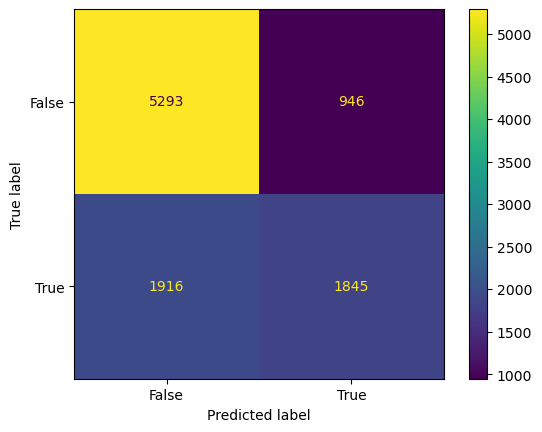

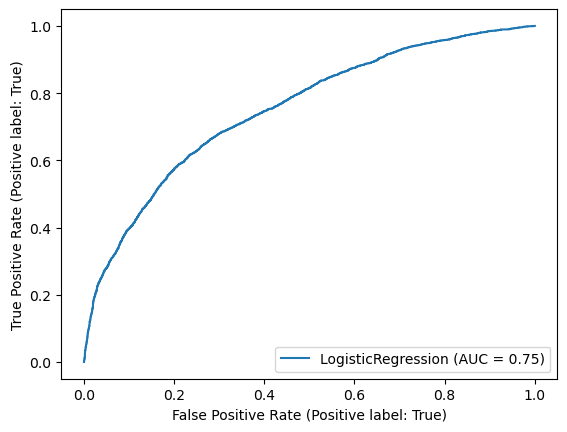

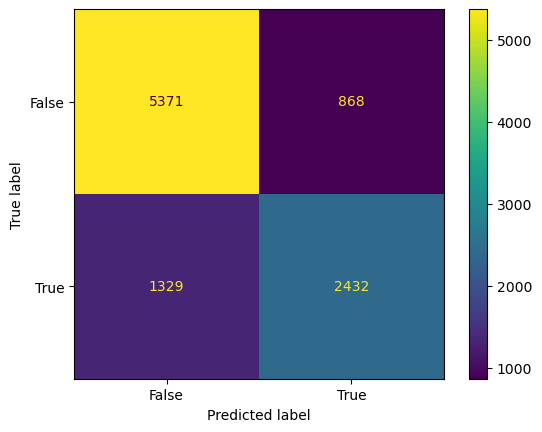

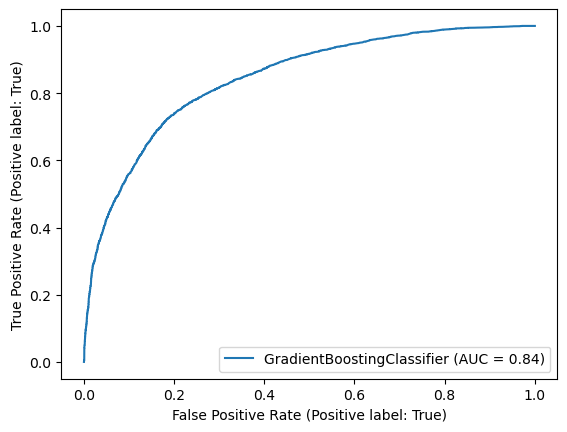

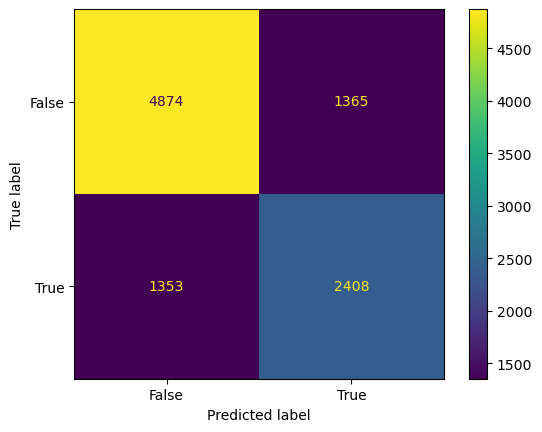

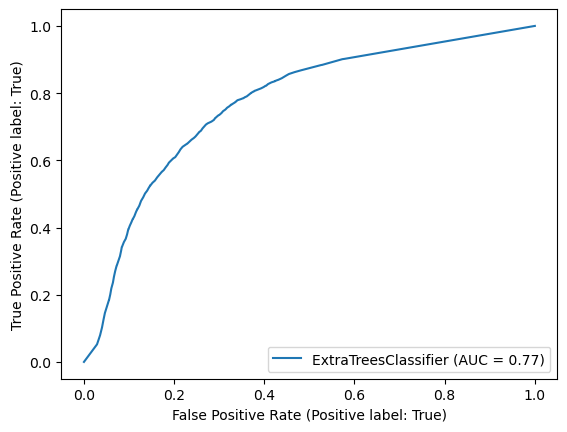

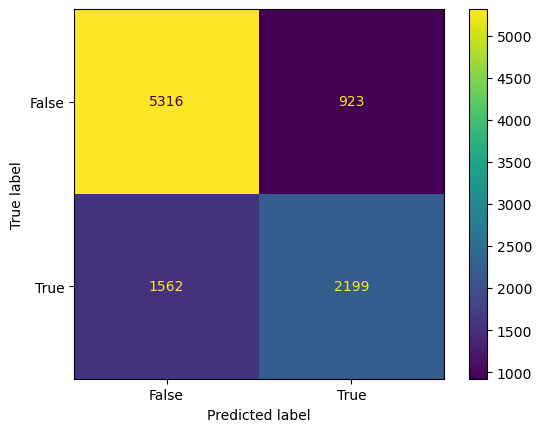

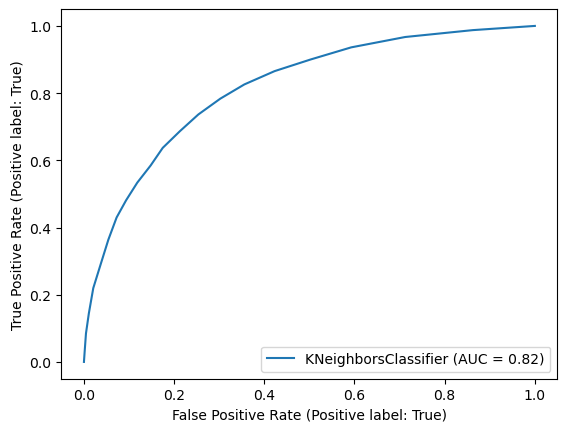

In [18]:
%%time

roc_auc_displays = {}
cm_displays = {}
mod_feature_importance = pd.DataFrame()

for mod in tqdm([LogisticRegression(), GradientBoostingClassifier(), ExtraTreesClassifier(), KNeighborsClassifier(20)]):
# for mod in tqdm([LogisticRegression(),]):
    # start = time()
    name = mod.__class__.__name__
    mod.fit(X_train,y_train)
    
    # confusion matrix
    cm_displays[name] = ConfusionMatrixDisplay.from_estimator(mod, X_test, y_test, labels=mod.classes_)
    # roc-auc curve
    roc_auc_displays[name] = RocCurveDisplay.from_estimator(mod,X_test,y_test)
    
    # permutation feature importance
    start = time()
    mod_fi = permutation_importance(mod,X_train,y_train)
    mod_feature_importance.loc[name, mod.feature_names_in_] = mod_fi['importances_mean']
    mod_feature_importance.loc[name,'time'] = round(time()-start)

In [19]:
mod_feature_importance

,trips_in_first_30_days,weekday_pct,avg_dist,city_Astapor,city_King's Landing,city_Winterfell,phone_Android,phone_iPhone,phone_unlisted,surge,special_user,time
LogisticRegression,0.026795,0.000070,0.005920,0.019310,0.031400,-0.000580,0.004850,0.008165,-0.000035,0.000010,0.030195,0.0
GradientBoostingClassifier,0.009595,0.064995,0.006945,0.010720,0.033465,-0.000085,0.007305,0.006335,0.000025,0.029225,0.019135,4.0
ExtraTreesClassifier,0.185240,0.273570,0.209115,0.036580,0.080875,0.011640,0.037165,0.032055,0.000310,0.122655,0.136670,60.0
KNeighborsClassifier,0.034550,0.067820,0.021960,0.009445,0.015730,0.003890,0.004195,0.004115,-0.000145,0.024025,0.029200,306.0


In [20]:
test = mod_feature_importance.copy()

for i,mname in enumerate(test.index):
    # make min value at least 0
    if test.iloc[i,:-1].min() < 0:
        test.iloc[i,:-1] = test.iloc[i,:-1]-test.iloc[i,:-1].min()
    # every
    test.iloc[i,:-1] = test.iloc[i,:-1]/test.iloc[i,:-1].max()
    
test.iloc[:,:-1].T.style\
    .background_gradient(cmap='Greens', axis=0,)\
    .format(formatter="{:.3f}")

,LogisticRegression,GradientBoostingClassifier,ExtraTreesClassifier,KNeighborsClassifier
trips_in_first_30_days,0.856,0.149,0.677,0.510
weekday_pct,0.020,1.000,1.000,1.000
avg_dist,0.203,0.108,0.764,0.325
city_Astapor,0.622,0.166,0.134,0.141
city_King's Landing,1.000,0.516,0.296,0.234
city_Winterfell,0.000,0.000,0.043,0.059
phone_Android,0.170,0.114,0.136,0.064
phone_iPhone,0.273,0.099,0.117,0.063
phone_unlisted,0.017,0.002,0.001,0.000
surge,0.018,0.450,0.448,0.356


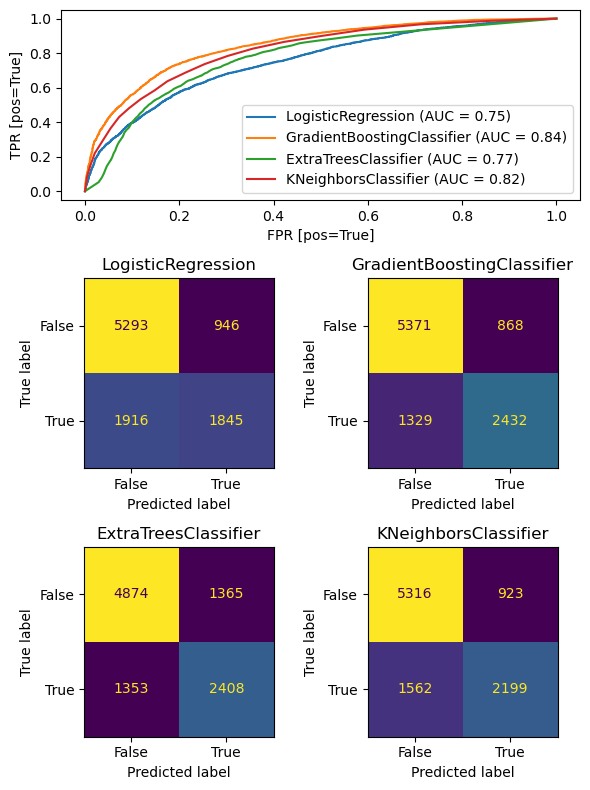

In [33]:
plt.figure(figsize=(6,8), tight_layout=True)

# CONFUSION MATRICES
for i,mname in enumerate(cm_displays.keys()):
    ax = plt.subplot(3,2,i+3)
    cm_displays[mname].plot(ax=ax, colorbar=False)
    plt.title(mname)

# ROC-AUC overlay
ax = plt.subplot(3,1,1)
for mname in cm_displays.keys():
    roc_auc_displays[mname].plot(ax=ax)
    # plt.legend(list(cm_displays.keys()))
    plt.ylabel('TPR [pos=True]')
    plt.xlabel('FPR [pos=True]')
plt.show()

##### Tuning

In [35]:
mod_feature_importance.index

Index(['LogisticRegression', 'GradientBoostingClassifier',
       'ExtraTreesClassifier', 'KNeighborsClassifier'],
      dtype='object')

In [82]:
# scipy stat distributions: https://nbpub.pythonanywhere.com/

tuning_grids = {
    # https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html
    'LogisticRegression':{
        'iterations': 120, 
        'grid': {
            'C': stats.halfnorm(0.01,2), # def=1, inverse of regularization strength (smaller=stronger), must be positive float
            'tol': stats.loguniform(1e-5, 1e-3, 0, 1), # def=1e-4, tolerance for stopping criteria
            'solver': ['liblinear',],
            'penalty':['l1','l2'],
        }
    },
    # https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsRegressor.html
    'KNeighborsClassifier':{
        'iterations': 60, 
        'grid': {
            'weights': ['uniform','distance'], # def='uniform', weight function used in prediction. uniform or distance based (inverse relation)
            'leaf_size': stats.nbinom(20,0.4,1), # def=30, 
            'p': stats.norm(1.5, 0.13), # default=2 (euclidean distance), 1-2, 1 is manhattan distance. in between is minkowsky
        }
    },
    # https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html
    'GradientBoostingClassifier':{
        'iterations': 60, 
        'grid': {
            'loss':['exponential','log_loss'],
            'learning_rate': stats.loguniform(.04,1,0,1), # def=0.1, float
            'n_estimators': stats.boltzmann(0.01,200,10), # def=100,  int
            'subsample': stats.loguniform(.2,1,0,1), # def=1.0, float from (0,1]
            'max_depth': stats.randint(2,10,0), # def=3, int [1,None=inf)
        }
    },
    # https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.ExtraTreesClassifier.html
    'ExtraTreesClassifier':{
        'iterations': 60, 
        'grid': {
            'n_estimators':stats.boltzmann(0.01,200,10), #def=100
            'criterion': ['gini', 'log_loss', 'entropy'], # def=gini
            'max_features': ['sqrt','log2',None], #def=sqrt
        }
    },
}


In [84]:
%%time

tune_results = pd.DataFrame()
tune_notes = {}

pbar = tqdm([LogisticRegression(max_iter=500,),
                 KNeighborsClassifier(20, n_jobs=-1),
                 GradientBoostingClassifier(),
                 ExtraTreesClassifier(n_jobs=-1),
                ])
for mod in pbar:
    name = mod.__class__.__name__
    pbar.set_description(name)
    
    # default scores
    mod.fit(X_train, y_train)
    y_pred = mod.predict(X_test)
    scores = score_pred(y_test,y_pred)
    for key in scores.keys():
        tune_results.loc[f'{name}_def',key] = scores[key]
        
    # tuning
    if name in tuning_grids.keys():
        grid = tuning_grids[name]['grid']
        its = tuning_grids[name]['iterations']
    else:
        continue
    start = time()
    clf = RandomizedSearchCV(mod, grid, n_iter=its, scoring='roc_auc', n_jobs=-1,
                                     refit=True, cv=10, random_state=42)
    tune_search = clf.fit(X_train, y_train)
    tune_time = round(time()-start)
    
    # tuned scores
    y_pred = tune_search.best_estimator_.predict(X_test)
    scores = score_pred(y_test,y_pred)
    for key in scores.keys():
        tune_results.loc[f'{name}_tuned',key] = scores[key]
    
    # note parameters, time, score improvement
    tune_notes[name] = {
        'best_params':tune_search.best_params_, 
        'time': tune_time, 'iterations':its, 
        'accuracy_factor': round(tune_results.loc[f'{name}_tuned','balanced_accuracy']/tune_results.loc[f'{name}_def','balanced_accuracy'],3)
                       }
    

ExtraTreesClassifier: 100%|██████████| 4/4 [12:40<00:00, 190.05s/it]      

CPU times: total: 1min 4s
Wall time: 12min 40s


**Initial Tuning** (after some troubleshooting)
 - added one more run for GradientBoosting

In [90]:
tune_results.sort_values('balanced_accuracy', ascending=False)

,accuracy,balanced_accuracy,precision,recall,roc_auc
GradientBoostingClassifier_tuned2,0.787,0.761,0.748,0.656,0.761
GradientBoostingClassifier_tuned,0.784,0.757,0.744,0.649,0.757
GradientBoostingClassifier_def,0.780,0.754,0.737,0.647,0.754
KNeighborsClassifier_def,0.752,0.718,0.704,0.585,0.718
KNeighborsClassifier_tuned,0.753,0.717,0.712,0.574,0.717
ExtraTreesClassifier_def,0.726,0.709,0.636,0.638,0.709
ExtraTreesClassifier_tuned,0.726,0.709,0.635,0.639,0.709
LogisticRegression_def,0.714,0.669,0.661,0.491,0.669
LogisticRegression_tuned,0.714,0.669,0.663,0.487,0.669


In [89]:
tune_notes

{'LogisticRegression': {'best_params': {'C': 0.021055724640252564,
   'penalty': 'l2',
   'solver': 'liblinear',
   'tol': 0.00021137059440645722},
  'time': 75,
  'iterations': 120,
  'accuracy_factor': 1.0},
 'KNeighborsClassifier': {'best_params': {'leaf_size': 43,
   'p': 1.3390839851525096,
   'weights': 'uniform'},
  'time': 117,
  'iterations': 60,
  'accuracy_factor': 0.999},
 'GradientBoostingClassifier': {'best_params': {'learning_rate': 0.21247026403332983,
   'loss': 'exponential',
   'max_depth': 5,
   'n_estimators': 47,
   'subsample': 0.9556008386843015},
  'time': 260,
  'iterations': 60,
  'accuracy_factor': 1.004},
 'ExtraTreesClassifier': {'best_params': {'criterion': 'entropy',
   'max_features': 'log2',
   'n_estimators': 155},
  'time': 301,
  'iterations': 60,
  'accuracy_factor': 1.0},
 'GradientBoostingClassifier_2': {'best_params': {'learning_rate': 0.12537073049383957,
   'loss': 'exponential',
   'max_depth': 5,
   'n_estimators': 182,
   'subsample': 0.923

In [88]:
%%time

# Final Tune for GBC, exponential only. more iterations
mod = GradientBoostingClassifier()
name = mod.__class__.__name__
grid =  {
            'loss':['exponential'],
            'learning_rate': stats.loguniform(.04,1,0,1), # def=0.1, float
            'n_estimators': stats.boltzmann(0.01,200,10), # def=100,  int
            'subsample': stats.loguniform(.2,1,0,1), # def=1.0, float from (0,1]
            'max_depth': stats.randint(2,10,0), # def=3, int [1,None=inf)
        }


start = time()
clf = RandomizedSearchCV(mod, grid, n_iter=120, scoring='roc_auc', n_jobs=-1,
                                 refit=True, cv=10, random_state=42)
tune_search = clf.fit(X_train, y_train)
tune_time = round(time()-start)

# tuned scores
y_pred = tune_search.best_estimator_.predict(X_test)
scores = score_pred(y_test,y_pred)
for key in scores.keys():
    tune_results.loc[f'{name}_tuned2',key] = scores[key]
    
tune_notes[f'{name}_2'] = {
    'best_params':tune_search.best_params_, 
    'time': tune_time, 'iterations':its, 
    'accuracy_factor': round(tune_results.loc[f'{name}_tuned2','balanced_accuracy']/tune_results.loc[f'{name}_def','balanced_accuracy'],3)
                   }

CPU times: total: 16.1 s
Wall time: 7min 35s


2it [00:23, 11.94s/it]


CPU times: total: 23.9 s
Wall time: 23.9 s


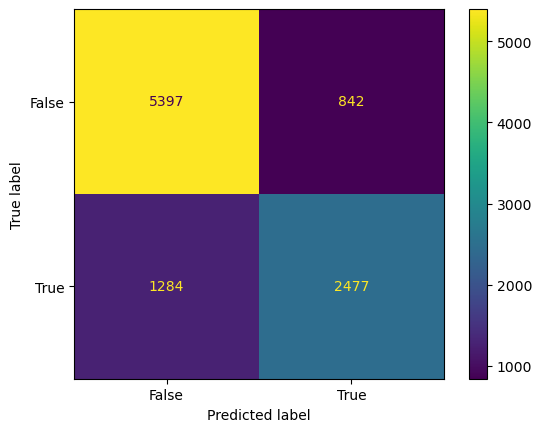

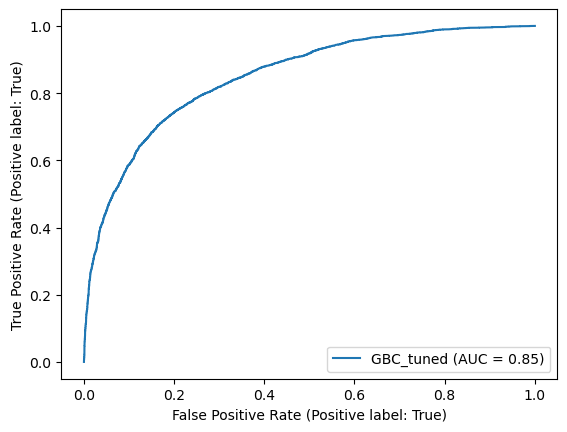

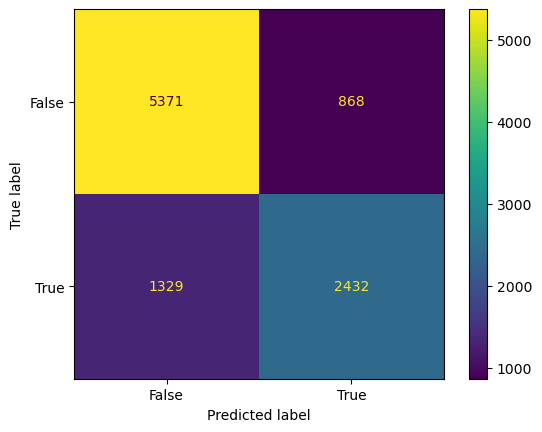

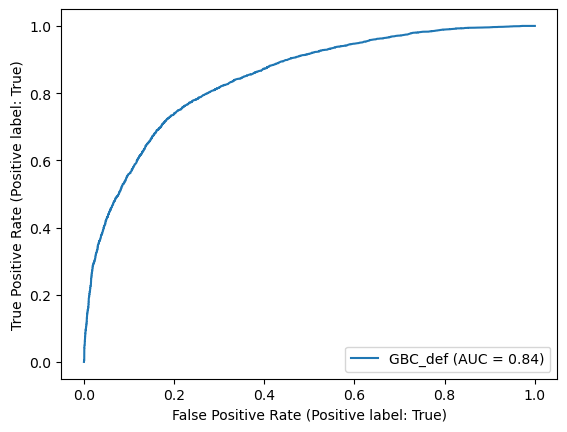

In [98]:
%%time

roc_auc_displays = {}
cm_displays = {}
mod_feature_importance = pd.DataFrame()
names = ['GBC_tuned', 'GBC_def',]

for i,mod in tqdm(enumerate([GradientBoostingClassifier(learning_rate=0.12537073049383957, loss='exponential', max_depth=5, 
                                            n_estimators=182, subsample=0.923582886940218), 
                 GradientBoostingClassifier(), 
                ])):
    name = names[i]
    mod.fit(X_train,y_train)
    
    # confusion matrix
    cm_displays[name] = ConfusionMatrixDisplay.from_estimator(mod, X_test, y_test, labels=mod.classes_)
    # roc-auc curve
    roc_auc_displays[name] = RocCurveDisplay.from_estimator(mod,X_test,y_test, name=name)
    
    # permutation feature importance
    start = time()
    mod_fi = permutation_importance(mod,X_train,y_train)
    mod_feature_importance.loc[name, mod.feature_names_in_] = mod_fi['importances_mean']
    mod_feature_importance.loc[name,'time'] = round(time()-start)

In [99]:
test = mod_feature_importance.copy()

for i,mname in enumerate(test.index):
    # make min value at least 0
    if test.iloc[i,:-1].min() < 0:
        test.iloc[i,:-1] = test.iloc[i,:-1]-test.iloc[i,:-1].min()
    # every
    test.iloc[i,:-1] = test.iloc[i,:-1]/test.iloc[i,:-1].max()
    
test.iloc[:,:-1].T.style\
    .background_gradient(cmap='Greens', axis=0,)\
    .format(formatter="{:.3f}")

,GBC_tuned,GBC_def
trips_in_first_30_days,0.226,0.158
weekday_pct,1.000,1.000
avg_dist,0.222,0.118
city_Astapor,0.115,0.171
city_King's Landing,0.414,0.533
city_Winterfell,0.004,0.000
phone_Android,0.077,0.105
phone_iPhone,0.070,0.098
phone_unlisted,0.002,0.002
surge,0.496,0.461


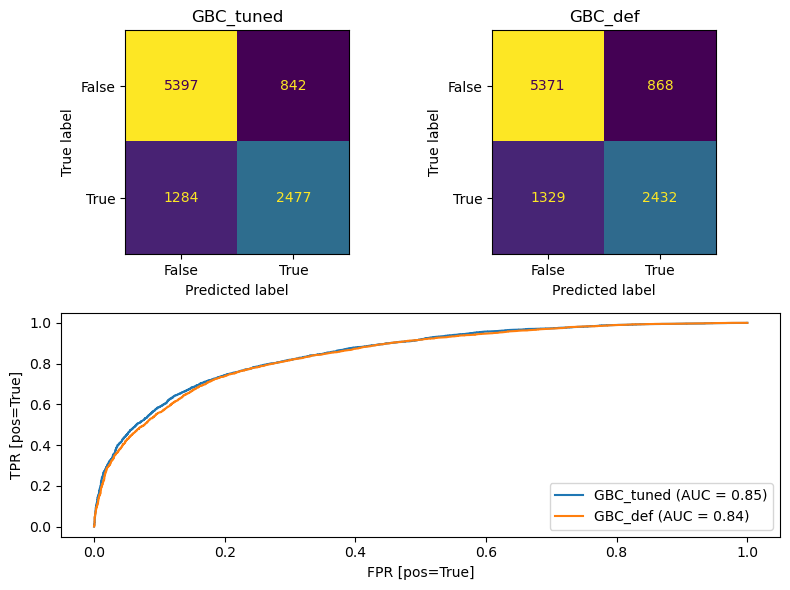

In [100]:
plt.figure(figsize=(8,6), tight_layout=True)

# CONFUSION MATRICES
for i,mname in enumerate(cm_displays.keys()):
    ax = plt.subplot(2,2,i+1)
    cm_displays[mname].plot(ax=ax, colorbar=False)
    plt.title(mname)

# ROC-AUC overlay
ax = plt.subplot(2,1,2)
for mname in cm_displays.keys():
    roc_auc_displays[mname].plot(ax=ax)
    # plt.legend(list(cm_displays.keys()))
    plt.ylabel('TPR [pos=True]')
    plt.xlabel('FPR [pos=True]')
plt.show()

### Final Model Evaluation 
 - *note*: `positive` *results are equivalent to retained users*
 - graphs only in this section, more words in the following section
   - graphs/tables generated in this section are presented again

In [20]:
# reload data and retrain model with determined hyperparameters
# make test predictions for sample interpretation
mdata = pd.read_parquet('model_data.parquet')
X_train, X_test, y_train, y_test = \
    train_test_split(mdata.drop(columns='retained'), mdata['retained'], 
                     test_size=0.2, random_state=42, stratify=mdata['retained'])

mod = GradientBoostingClassifier(learning_rate=0.12537073049383957, loss='exponential', 
                                 max_depth=5, n_estimators=182, subsample=0.923582886940218)
name = mod.__class__.__name__
start = time()
mod.fit(X_train,y_train)

test_pred = pd.DataFrame(mod.predict(X_test), index=X_test.index)
test_prob = pd.DataFrame(mod.predict_proba(X_test), index=X_test.index)

fit_predict_time = round(time()-start)

final_results = X_test
final_results.loc[:,'Actual'] = y_test
final_results.loc[:,'Prob'] = test_prob.iloc[:,1]
final_results.loc[:,'Pred'] = test_pred

In [21]:
# final train scoring, 10 fold cross validation
final_cv = pd.DataFrame()
start = time()
cv = cross_validate(mod, X_train, y_train, cv=10, n_jobs=-1,
                    scoring=['accuracy','balanced_accuracy','precision','recall', 'roc_auc'])

cvk = pd.Series(cv.keys())
cvk = cvk[cvk.str.startswith('test_')]
for k in cvk.values:
    final_cv.loc['training_CV', k.replace('test_','')] = round(np.mean(cv[k]),3)
final_cv.loc['training_CV','time'] = round(time()-start)


test_scores = score_pred(y_test,test_pred)
for key in test_scores.keys():
    final_cv.loc['testing',key] = test_scores[key]
final_cv.loc['testing','time'] = fit_predict_time


final_cv

,accuracy,balanced_accuracy,precision,recall,roc_auc,time
training_CV,0.786,0.760,0.742,0.660,0.850,14.0
testing,0.788,0.762,0.747,0.659,0.762,9.0


CPU times: total: 8.05 s
Wall time: 8.04 s


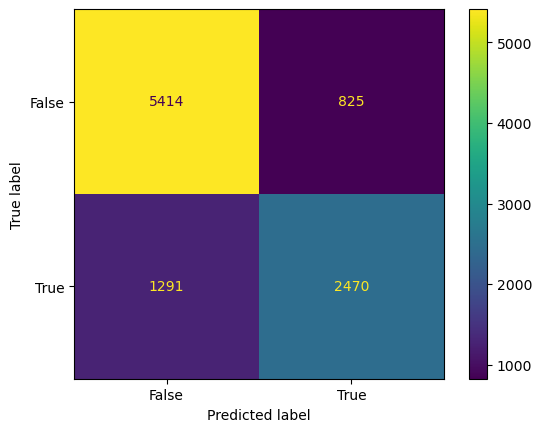

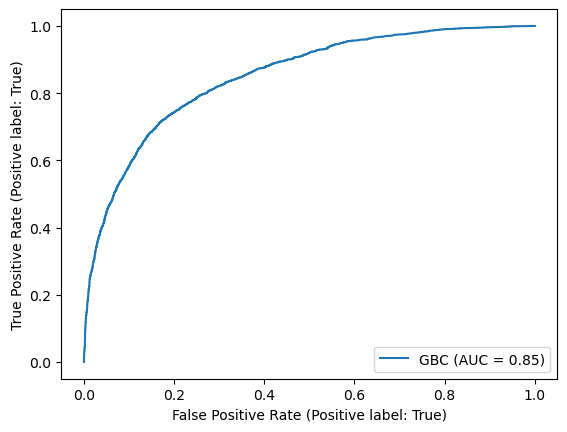

In [23]:
%%time
feature_imp = pd.DataFrame()

cm = ConfusionMatrixDisplay.from_estimator(mod, X_test, y_test, labels=mod.classes_)
roc = RocCurveDisplay.from_estimator(mod,X_test,y_test, name='GBC')

mod_fi = permutation_importance(mod,X_train,y_train)
feature_imp.loc[name, mod.feature_names_in_] = mod_fi['importances_mean']

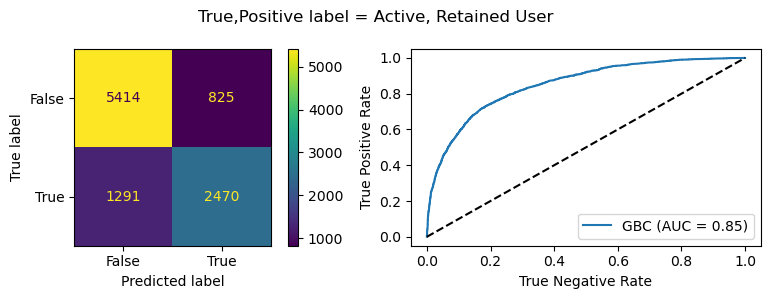

In [184]:
plt.figure(figsize=(8,3), tight_layout=True)
ax = plt.subplot(121)
cm.plot(ax=ax)
ax = plt.subplot(122)
roc.plot(ax=ax)
plt.xlabel('True Negative Rate')
plt.ylabel('True Positive Rate')
plt.plot((0,1),(0,1),'k--')
plt.suptitle('True,Positive label = Active, Retained User')
plt.savefig('final_model_results.png')
plt.show()

In [183]:
(feature_imp.T.sort_values('GradientBoostingClassifier',ascending=False)*100/feature_imp.max().max())\
    .style.background_gradient(cmap='Spectral').format(formatter="{:.2f}")

,GradientBoostingClassifier
weekday_pct,100.00
surge,55.71
city_King's Landing,42.57
trips_in_first_30_days,24.48
avg_dist,21.70
special_user,20.30
city_Astapor,11.48
phone_Android,8.86
phone_iPhone,6.88
city_Winterfell,0.70


In [120]:
# samp = X_test.sample(10, random_state=42).round(2)
# scaled_cols = ['trips_in_first_30_days','weekday_pct','avg_dist', 'surge']
# raw_cols = ['trips_in_first_30_days','weekday_pct','avg_dist', 'avg_surge','surge_pct']
# samp.loc[:,'True'] = y_test.loc[samp.index]
# samp.loc[:,'Prob'] = test_prob.loc[samp.index,1].round(2)
# samp.loc[:,'Pred'] = test_pred.loc[samp.index]
# samp

# raw_sample = d.loc[samp.index, raw_cols]
# raw_sample.loc[:,'True'] = y_test.loc[samp.index]
# raw_sample.loc[:,'Pred'] = test_prob.loc[samp.index,1]
# raw_sample.loc['median',:] = d[raw_cols].median()
# raw_sample.loc['min',:] = d[raw_cols].min()
# raw_sample.loc['max',:] = d[raw_cols].max()

# raw_sample

In [143]:
samp_scaled = X_test.sample(10, random_state=42)
samp = samp_scaled.copy()
scaled_cols = ['trips_in_first_30_days','weekday_pct','avg_dist', 'surge']
raw_cols = ['trips_in_first_30_days','weekday_pct','avg_dist', 'avg_surge','surge_pct']

samp.drop(columns=scaled_cols, inplace=True)
samp.drop(columns=samp.columns[samp.columns.str.startswith('city_')], inplace=True)
samp.drop(columns=samp.columns[samp.columns.str.startswith('phone_')], inplace=True)

samp.loc[:,raw_cols] = d.loc[samp.index, raw_cols]
samp.loc[:,'city'] = d.loc[samp.index, 'city']
samp.loc[:,'phone'] = d.loc[samp.index, 'phone']
samp.loc[:,'special_user'] = samp.special_user.astype(bool)

samp.loc[:,'Retained_User'] = y_test.loc[samp.index]
samp.loc[:,'Prob'] = test_prob.loc[samp.index,1].round(2)
samp.loc[:,'Pred'] = test_pred.loc[samp.index]

# samp.loc['median',raw_cols] = d[raw_cols].median()
# samp.loc['min',raw_cols] = d[raw_cols].min()
# samp.loc['max',raw_cols] = d[raw_cols].max()

# samp

,special_user,trips_in_first_30_days,weekday_pct,avg_dist,avg_surge,surge_pct,city,phone,Retained_User,Prob,Pred
41691,False,1,62.5,3.46,1.00,0.0,King's Landing,iPhone,True,0.80,True
25112,False,0,100.0,3.23,1.00,0.0,Astapor,Android,False,0.07,False
1838,True,3,68.0,4.27,1.09,16.0,Astapor,iPhone,True,0.90,True
45707,True,5,100.0,16.14,1.00,0.0,King's Landing,Android,True,0.39,False
43555,True,2,72.7,4.45,1.20,18.2,Winterfell,iPhone,True,0.80,True
12851,True,2,50.0,2.43,1.00,0.0,Astapor,Android,True,0.12,False
13504,False,12,63.6,2.36,1.10,15.9,King's Landing,iPhone,True,0.91,True
20181,True,0,100.0,4.81,1.00,0.0,Astapor,Android,False,0.10,False
27778,False,1,41.2,1.73,1.07,11.8,King's Landing,iPhone,True,0.95,True
44963,False,1,0.0,7.44,1.00,0.0,Astapor,iPhone,False,0.06,False


In [181]:
samp.style\
    .background_gradient(cmap='Pastel1', subset='city', gmap=samp.city.map(lambda x: list(samp.city.unique()).index(x)))\
    .background_gradient(cmap='Pastel2', subset='phone', gmap=samp.phone.map(lambda x: list(samp.phone.unique()).index(x)))\
    .background_gradient(cmap='Set3', subset='special_user')\
    .background_gradient(cmap='PiYG', subset='trips_in_first_30_days', gmap=samp_scaled.trips_in_first_30_days)\
    .background_gradient(cmap='PiYG', subset='weekday_pct', gmap=samp_scaled.weekday_pct)\
    .background_gradient(cmap='PiYG', subset='avg_dist', gmap=samp_scaled.avg_dist)\
    .background_gradient(cmap='PiYG', subset=['avg_surge','surge_pct'], gmap=samp_scaled.surge)\
    .background_gradient(cmap='Spectral', subset=['Retained_User','Prob','Pred'], 
                         gmap=samp.Retained_User==samp.Pred)\
    .format(formatter="{:.2f}", subset=['weekday_pct','avg_dist','avg_surge','surge_pct','Prob'])

,special_user,trips_in_first_30_days,weekday_pct,avg_dist,avg_surge,surge_pct,city,phone,Retained_User,Prob,Pred
41691,False,1,62.50,3.46,1.00,0.00,King's Landing,iPhone,True,0.80,True
25112,False,0,100.00,3.23,1.00,0.00,Astapor,Android,False,0.07,False
1838,True,3,68.00,4.27,1.09,16.00,Astapor,iPhone,True,0.90,True
45707,True,5,100.00,16.14,1.00,0.00,King's Landing,Android,True,0.39,False
43555,True,2,72.70,4.45,1.20,18.20,Winterfell,iPhone,True,0.80,True
12851,True,2,50.00,2.43,1.00,0.00,Astapor,Android,True,0.12,False
13504,False,12,63.60,2.36,1.10,15.90,King's Landing,iPhone,True,0.91,True
20181,True,0,100.00,4.81,1.00,0.00,Astapor,Android,False,0.10,False
27778,False,1,41.20,1.73,1.07,11.80,King's Landing,iPhone,True,0.95,True
44963,False,1,0.00,7.44,1.00,0.00,Astapor,iPhone,False,0.06,False


### Results and Interpretation
 - **approach and results:** (graphs, tables, and detailed result printouts below)
   - data treatment
     - dropped features showed little correlation to target.
     - remaining categorical features were one-hot-encoded and remaining numerical features were z-score normalized.
     - surge features combined into one `surge=avg_surge*surge_pct`
     - split data with target stratification, used 80% for training
   - model selection
     - considered various classifiers from `scikit-learn`, advanced LogisticRegression, GradientBoosting, ExtraTrees, and KNeighbors classifiers for hyperparameter tuning
     - selected GradientBoostingClassifier with tuned hyperparameters for final model
     - considered various metrics, all roughly scaled with accuracy and balanced accuracy
   - model validity
     - test scores: `{'accuracy': 0.788, 'balanced_accuracy': 0.762, 'precision': 0.748, 'recall': 0.658, 'roc_auc': 0.762}`
     - decent overall accuracy. 
       - model better at truly identifying users that were not retained. they outnumber retained users roughly 2:1 in the overall dataset.
       - in other words, precision is better than recall. the model is better at avoiding false positives (prediciting a non-active user to be retained) than finding all the positives (retained users).
 - **alternatives**
     - include features previously dropped (rating, etc)
     - different data treatment: different encoding/scaling strategies, efforts into feature engineering/combinations, feature decomposition via PCA
       - tailored treatment for each model with pipelines
     - classification models outside of `scikit-learn` API. ex: XGBoost, CatBoost, simple ANN model
     - aggregate top performing models for possible performance gain over just one
 - **concerns**
   - was standard scaling appropriate for numerical features? not all show normal distributions
   - performance variation across encoded features (city, phone) seems high. 
     - Model predictions for city or phone associated with a low retention rate tend to have no recall
     - would a different encoding strategy be better? *Ordinal* instead of *OneHot*
   - similarly, should collinear features have been addressed?
     - for ex: maybe city and first month trips?
     - users with high `surge` are less likely to have/want alternatives to the service
   - does overall accuracy meet client's expectations?
 - **model insights to improve long-term rider retention**
   - the model's feature importances (table below) can provide insights into learning what contributes to user retention and what characteristics active users have
     - as mentioned, `surge` and also `weekday_pct` are very important features for the model. while surge may relate strongly to retention rate, it doesn't make sense that users will be more likely to stay on the service because they like paying higher prices. while surge rates may be appropriate for pricing and demand, lowering them could benefit user retention for a wider variety of users.
   - the client may adjust their service or UI they provide to users from certain cities or with certain phones to improve retention.
     - what are differences between users from Astapor and King's Landing that contribute to the former's lower retention rate?
     - why are Android users much less likely to stay on the service? could it simply be an issue specific to their Android app?
     - can they incentivize *Ultimate Black* user status to populations that are less likely to stay active?

In [324]:
print(score_pred(y_test,test_pred))

{'accuracy': 0.788, 'balanced_accuracy': 0.762, 'precision': 0.748, 'recall': 0.658, 'roc_auc': 0.762}


![model metrics](./final_model_results.png)
<br>
---
<br>

![feature importance, sample results](./results_interpretation_table_img.png)

![model metrics](GITHUB LINK)
<br>
---
<br>

![feature importance, sample results](GITHUB LINK)

**Sample Results Interpretation**
 - correct predictions were mostly confident (probability close to 0 or 1)
 - incorrect predictions both false positives, should `phone=Android` have helped the model more to avoid these mistakes?
   - `45707` 
     - user may have seemed likely to be retained given city, user stats, trips in first month, and relatively high average distance.
   - `12851`
     - similar to other user, but not as high distance traveled or surge. also from Astapor, which had lower retention rates than other cities.
---

**Feature Based Results**
  - how does model perform for various categories (city, phone, special user)
  - how does model perform on each side of a given cutoff for numerical features (first month trips, weekday, surge, distance)
    - *for "avg" based cutoff, note that feature means were determined from the training data. reported results are from the test data*

In [271]:
city_cols = final_results.columns[final_results.columns.str.startswith('city_')]

print('city | retained users | not retained\n')

for c in city_cols:
    sub = final_results[final_results[c]>0]
    print(c, '|', sub[sub.Actual==True].shape[0], '|', sub[sub.Actual==False].shape[0])
    print('model pred'.rjust(len(c)),  f'| {sub[sub.Pred==True].shape[0]} | {sub[sub.Pred==False].shape[0]}',)
    print(score_pred(sub['Actual'],sub['Pred']),'\n')

city | retained users | not retained

city_Astapor | 880 | 2396
  model pred | 549 | 2727
{'accuracy': 0.8, 'balanced_accuracy': 0.686, 'precision': 0.705, 'recall': 0.44, 'roc_auc': 0.686} 

city_King's Landing | 1294 | 774
         model pred | 1422 | 646
{'accuracy': 0.75, 'balanced_accuracy': 0.716, 'precision': 0.773, 'recall': 0.849, 'roc_auc': 0.716} 

city_Winterfell | 1587 | 3069
     model pred | 1340 | 3316
{'accuracy': 0.796, 'balanced_accuracy': 0.754, 'precision': 0.738, 'recall': 0.623, 'roc_auc': 0.754} 



 - low recall for Astapor. low overall retention rate led model to miss more positives

In [268]:
phone_cols = final_results.columns[final_results.columns.str.startswith('phone_')]

print('phone | retained users | not retained\n')

for p in phone_cols:
    sub = final_results[final_results[p]>0]
    print(p, '|', sub[sub.Actual==True].shape[0], '|', sub[sub.Actual==False].shape[0])
    print('model pred'.rjust(len(p)),  f'| {sub[sub.Pred==True].shape[0]} | {sub[sub.Pred==False].shape[0]}',)
    print(score_pred(sub['Actual'],sub['Pred']),'\n')

phone | retained users | not retained

phone_Android | 611 | 2387
   model pred | 310 | 2688
{'accuracy': 0.828, 'balanced_accuracy': 0.643, 'precision': 0.652, 'recall': 0.331, 'roc_auc': 0.643} 

phone_iPhone | 3119 | 3802
  model pred | 2974 | 3947
{'accuracy': 0.77, 'balanced_accuracy': 0.766, 'precision': 0.757, 'recall': 0.722, 'roc_auc': 0.766} 

phone_unlisted | 31 | 50
    model pred | 27 | 54
{'accuracy': 0.827, 'balanced_accuracy': 0.805, 'precision': 0.815, 'recall': 0.71, 'roc_auc': 0.805} 



 - low recall for Android. low overall retention rate led model to miss more positives

In [267]:
print('user status | retained users | not retained\n')

for b in final_results.special_user.unique():
    sub = final_results[final_results['special_user']==b]
    print('special user:',bool(b), '|', sub[sub.Actual==True].shape[0], '|', sub[sub.Actual==False].shape[0])
    print('model pred'.rjust(14+len(str(bool(b)))),  f'| {sub[sub.Pred==True].shape[0]} | {sub[sub.Pred==False].shape[0]}',)
    print(score_pred(sub['Actual'],sub['Pred']),'\n')

user status | retained users | not retained

special user: True | 1886 | 1855
        model pred | 1875 | 1866
{'accuracy': 0.776, 'balanced_accuracy': 0.776, 'precision': 0.779, 'recall': 0.775, 'roc_auc': 0.776} 

special user: False | 1875 | 4384
         model pred | 1436 | 4823
{'accuracy': 0.795, 'balanced_accuracy': 0.722, 'precision': 0.706, 'recall': 0.541, 'roc_auc': 0.722} 



 - non special users similarly low recall to Android / Astapor users, but not as bad in comparison

In [264]:
cutoff = 1

print('first month trips | retained users | not retained\n')

sub = final_results[final_results['trips_in_first_30_days']<cutoff]
print(f'0-{cutoff-1} first month trips', '|', sub[sub.Actual==True].shape[0], '|', sub[sub.Actual==False].shape[0])
print('model pred'.rjust(21),  f'| {sub[sub.Pred==True].shape[0]} | {sub[sub.Pred==False].shape[0]}',)
print(score_pred(sub['Actual'],sub['Pred']),'\n')

sub = final_results[final_results['trips_in_first_30_days']>=cutoff]
print(f'{cutoff} or more first month trips', '|', sub[sub.Actual==True].shape[0], '|', sub[sub.Actual==False].shape[0])
print('model pred'.rjust(27),  f'| {sub[sub.Pred==True].shape[0]} | {sub[sub.Pred==False].shape[0]}',)

print(score_pred(sub['Actual'],sub['Pred']),'\n')

first month trips | retained users | not retained

0-0 first month trips | 3224 | 6015
           model pred | 2699 | 6540
{'accuracy': 0.789, 'balanced_accuracy': 0.749, 'precision': 0.736, 'recall': 0.616, 'roc_auc': 0.749} 

1 or more first month trips | 537 | 224
                 model pred | 612 | 149
{'accuracy': 0.775, 'balanced_accuracy': 0.681, 'precision': 0.799, 'recall': 0.911, 'roc_auc': 0.681} 



 - users without a trip in the first month suffer similar fate of low recall mentioned above

In [259]:
cutoff = 0
feature = 'weekday_pct'

print(feature, '| retained users | not retained\n')

sub = final_results[final_results[feature]<cutoff]
print(f'below avg {feature}', '|', sub[sub.Actual==True].shape[0], '|', sub[sub.Actual==False].shape[0])
print('model pred'.rjust(10+len(feature)),  f'| {sub[sub.Pred==True].shape[0]} | {sub[sub.Pred==False].shape[0]}',)
print(score_pred(sub['Actual'],sub['Pred']),'\n')

sub = final_results[final_results[feature]>=cutoff]
print(f'above avg {feature}', '|', sub[sub.Actual==True].shape[0], '|', sub[sub.Actual==False].shape[0])
print('model pred'.rjust(10+len(feature)),  f'| {sub[sub.Pred==True].shape[0]} | {sub[sub.Pred==False].shape[0]}',)

print(score_pred(sub['Actual'],sub['Pred']),'\n')

weekday_pct | retained users | not retained

below avg weekday_pct | 1774 | 2777
           model pred | 1568 | 2983
{'accuracy': 0.776, 'balanced_accuracy': 0.754, 'precision': 0.741, 'recall': 0.655, 'roc_auc': 0.754} 

above avg weekday_pct | 1987 | 3462
           model pred | 1743 | 3706
{'accuracy': 0.797, 'balanced_accuracy': 0.768, 'precision': 0.753, 'recall': 0.661, 'roc_auc': 0.768} 



 - balanced performance for weekday_pct. sample data had feature concentrated at the extremes

In [257]:
cutoff = 0
feature = 'surge'

print(feature, '| retained users | not retained\n')

sub = final_results[final_results[feature]<cutoff]
print(f'below avg {feature}', '|', sub[sub.Actual==True].shape[0], '|', sub[sub.Actual==False].shape[0])
print('model pred'.rjust(10+len(feature)),  f'| {sub[sub.Pred==True].shape[0]} | {sub[sub.Pred==False].shape[0]}',)
print(score_pred(sub['Actual'],sub['Pred']),'\n')

sub = final_results[final_results[feature]>=cutoff]
print(f'above avg {feature}', '|', sub[sub.Actual==True].shape[0], '|', sub[sub.Actual==False].shape[0])
print('model pred'.rjust(10+len(feature)),  f'| {sub[sub.Pred==True].shape[0]} | {sub[sub.Pred==False].shape[0]}',)
print(score_pred(sub['Actual'],sub['Pred']),'\n')

surge | retained users | not retained

below avg surge | 2726 | 5159
     model pred | 2299 | 5586
{'accuracy': 0.794, 'balanced_accuracy': 0.754, 'precision': 0.739, 'recall': 0.624, 'roc_auc': 0.754} 

above avg surge | 1035 | 1080
     model pred | 1012 | 1103
{'accuracy': 0.765, 'balanced_accuracy': 0.765, 'precision': 0.766, 'recall': 0.749, 'roc_auc': 0.765} 



 - relatively balanced performance for `surge`, the only engineered feature, despite most users being below the surge average

In [258]:
cutoff = 0
feature = 'avg_dist'

print(feature, '| retained users | not retained\n')

sub = final_results[final_results[feature]<cutoff]
print(f'below avg {feature}', '|', sub[sub.Actual==True].shape[0], '|', sub[sub.Actual==False].shape[0])
print('model pred'.rjust(10+len(feature)),  f'| {sub[sub.Pred==True].shape[0]} | {sub[sub.Pred==False].shape[0]}',)
print(score_pred(sub['Actual'],sub['Pred']),'\n')

sub = final_results[final_results[feature]>=cutoff]
print(f'above avg {feature}', '|', sub[sub.Actual==True].shape[0], '|', sub[sub.Actual==False].shape[0])
print('model pred'.rjust(10+len(feature)),  f'| {sub[sub.Pred==True].shape[0]} | {sub[sub.Pred==False].shape[0]}',)
print(score_pred(sub['Actual'],sub['Pred']),'\n')

avg_dist | retained users | not retained

below avg avg_dist | 2774 | 4092
        model pred | 2536 | 4330
{'accuracy': 0.787, 'balanced_accuracy': 0.772, 'precision': 0.759, 'recall': 0.694, 'roc_auc': 0.772} 

above avg avg_dist | 987 | 2147
        model pred | 775 | 2359
{'accuracy': 0.789, 'balanced_accuracy': 0.727, 'precision': 0.711, 'recall': 0.558, 'roc_auc': 0.727} 



 - relatively balanced performance

---

In [13]:
print(f'True Positives {2470/(1291+2470):.2f} | {1291+2470} total')
print(f'False Positives {1291/(1291+2470):.2f}')
print(f'True Negatives {5414/(825+5414):.2f} | {825+5414} total')
print(f'False Negatives {825/(825+5414):.2f}')

True Positives 0.66 | 3761 total
False Positives 0.34
True Negatives 0.87 | 6239 total
False Negatives 0.13
